# Index
<ol>
    <li><a href="#setup_and_data_download">Setup and data download</a>
    <li><a href="#training_data_visualization">Training data visualization</a>
    <li><a href="#data_cleaning_and_feature_engineering">Feature engineering</a>
    <li><a href="#model_validation">Data preprocessing</a>
    <li><a href="#model_training">Model training</a>
    <li><a href="#model_predictions">Model predictions</a>
       
           
            

<br>
<br>
<a id="setup_and_data_download"> </a>
# 1. Setup and data download

<br>
## 1.1 Libraries setup

### Import the fastai library

In [4]:
from fastai.imports import *
from fastai.transforms import *
import fastai.conv_learner
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.structured import *
from fastai.column_data import *

### Import functionality libraries

In [5]:
import os # Create directories, list files
import zipfile # Extract compressed files
import numpy as np # Linear algebra, sorting and selecting
import pandas as pd # Dataframes and csv I/O
import matplotlib.pyplot as plt # Plotting histograms
from PIL import Image # Python Image Library, get sizes from images
from collections import Counter # Class for counting purposes
from math import exp # Exponential function
from sklearn.metrics import classification_report, precision_recall_fscore_support, fbeta_score ,roc_auc_score, roc_curve, auc # Useful metrics for single label classification
import time # Measuring elapsed time
import itertools as it
from torch import FloatTensor
import torch
from torch.nn import *
from functools import reduce
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import KFold

### Check CUDA is enabled

It's important that you have a working Nvidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA.

In [6]:
torch.cuda.is_available()

False

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN

In [7]:
torch.backends.cudnn.enabled

True

<br>
## 1.2 Enviroment setup

### Environment

The environment overview

```
./input
│      
│
└─── train
│   │   train.csv
│
└─── test
│   │   test.csv
│   
└─── submission
    │   submission.csv
```

### Windows or Unix
Set the separators depending on the OS

In [8]:
OS = "Linux"

In [9]:
if OS == "Windows":
    s = "\\"
elif OS == "Linux":
    s = "/"
else:
    print("Not a valid OS")

### Initialize the environment variables

In [10]:
TRAIN_DIR = "train"
TEST_DIR = "test"
SUBMISSION_DIR = "submission"
INPUT_PATH = f'.{s}input'
TRAIN_PATH = f'{INPUT_PATH}{s}{TRAIN_DIR}'
TEST_PATH = f'{INPUT_PATH}{s}{TEST_DIR}'
SUBMISSION_PATH = f'{INPUT_PATH}{s}{SUBMISSION_DIR}'

<br>
## 1.2 Data setup

### Create the input directory

In [11]:
if not os.path.exists(f'{INPUT_PATH}'):
    os.mkdir(f'{INPUT_PATH}')

### Create the train, test and submission directory

In [12]:
if not os.path.exists(TRAIN_PATH): 
    os.mkdir(TRAIN_PATH)
print("Train directory ready")

if not os.path.exists(TEST_PATH): 
    os.mkdir(TEST_PATH)
print("Test directory ready")

if not os.path.exists(SUBMISSION_PATH): 
    os.mkdir(SUBMISSION_PATH)
print("Submmission directory ready")

Train directory ready
Test directory ready
Submmission directory ready


### Extract the data

Extract the data in the train directory and submission directory.<br>
Set the flag to false when already extracted.

In [13]:
extract_data = False

In [14]:
train_csv_files = ["train.csv"]
test_csv_files = ["test.csv"]

### Check environment is correctly initialized

In [15]:
expected_dir = [TRAIN_DIR,  TEST_DIR, SUBMISSION_DIR]
current_dir = os.listdir(INPUT_PATH)
print(current_dir)
if set(expected_dir).issubset(set(current_dir)): print("Everything is correct")

['test_processed_1', 'train_general_df', 'train_processed_1', 'submission', 'test_david1', 'test', 'train_david1', 'train', 'test_general_df']
Everything is correct


<br>
<br>
<a id="data_preprocessing"> </a>
# 2. Training data visualization
Create a flag to iterate faster if we have a working model.

In [16]:
visualization = True

<br>
## 2.1 Generate the dataframes

Extract the names of the csv files in the train folder.<br>


In [17]:
train_table_names = [train_table_name[:-4] for train_table_name in os.listdir(TRAIN_PATH) if train_table_name[-4:] == ".csv"]
test_table_names = [test_table_name[:-4] for test_table_name in os.listdir(TEST_PATH) if test_table_name[-4:] == ".csv"]
print(train_table_names)
print(test_table_names)

['train']
['test_challenge']


To iterate faster we define a maximum sample_size (to train on the full dataset set it to None).

In [18]:
sample_size = None

Create the dictionary that links each name to the corresponging dataframe.<br>

In [19]:
generate_datasets = True

In [20]:
if generate_datasets:
    train_tables_dict = {train_table_name : pd.read_csv(f'{TRAIN_PATH}{s}{train_table_name}.csv', nrows=sample_size, low_memory=False, encoding= "ISO-8859-1") for train_table_name in train_table_names}
    test_tables_dict = {test_table_name : pd.read_csv(f'{TEST_PATH}{s}{test_table_name}.csv', nrows=sample_size, low_memory=False, encoding= "ISO-8859-1") for test_table_name in test_table_names}

<br><br>
## 2.2 Preliminary dataframes exploration

### Data description

In [21]:
if visualization:
    train_tables_dict["train"].info()
    display(train_tables_dict["train"].columns.values)
    display(train_tables_dict["train"].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1617 entries, 0 to 1616
Data columns (total 85 columns):
MDR                                         1617 non-null int64
ID                                          1617 non-null object
NHC                                         1617 non-null int64
start_neutropenico                          1617 non-null object
start_FN                                    1617 non-null object
days_between                                832 non-null float64
days_in_hospital                            1617 non-null int64
hospital_stay_w_FN                          1617 non-null int64
prev_hospital_stay                          1617 non-null int64
birth_year                                  1617 non-null int64
Gender                                      1617 non-null object
emergency                                   1617 non-null int64
num_movements                               1617 non-null int64
num_consult                                 1617 non-nul

array(['MDR', 'ID', 'NHC', 'start_neutropenico', 'start_FN', 'days_between', 'days_in_hospital',
       'hospital_stay_w_FN', 'prev_hospital_stay', 'birth_year', 'Gender', 'emergency', 'num_movements',
       'num_consult', 'share_room_MDR', 'dummy_LAM', 'dummy_others.LL', 'dummy_Cancer.linfoproliferativo',
       'dummy_SMD', 'dummy_LAL', 'dummy_EICH', 'dummy_Leucemia.cronica', 'dummy_SMPC', 'dummy_Cancer.solido',
       'dummy_LMC', 'dummy_TLPT', 'dummy_others.LM', 'dummy_Mieloma.like', 'dummy_LLC', 'antibiotic_count',
       'days_after_anti', 'AMIKACINA_.MG.', 'AMOXICILINA_.MG.', 'AMPICILINA_.MG.', 'AZITROMICINA_VIAL_.MG.',
       'AZTREONAM_.MG.', 'CEFAZOLINA_.MG.', 'CEFIXIMA_.MG.', 'CEFOTAXIMA_.MG.', 'CEFOXITINA_.MG.',
       'CEFTAROLINA_FOSAMIL_.MG.', 'CEFTAZIDIMA_.MG.', 'CEFTIBUTENO_.MG.', 'CEFTOLOZANO_.UND.',
       'CEFTRIAXONA_.MG.', 'CEFUROXIMA.AXETILO_.MG.', 'CIPROFLOXACINO_.MG.', 'CLARITROMICINA_.MG.',
       'CLINDAMICINA_.MG.', 'CLOXACILINA_.MG.', 'COTRIMOXAZOL_FORTE_.

,MDR,ID,NHC,start_neutropenico,start_FN,days_between,days_in_hospital,hospital_stay_w_FN,prev_hospital_stay,birth_year,...,TOBRAMICINA_NEB_.MG.,VANCOMICINA_.MG.,Auto_TP,Alo_TP,room_list,mucositis,cito_group_3,cito_group_1,cito_group_2,Past_positive_result_from
0,0,374-1,404,2007-12-11,2008-01-01,NaN,28,1,3,1941,...,0,8000.0,1,0,E02403,0,1,0,0,Culture
1,0,398-1,1897,2007-12-28,2008-01-01,NaN,8,1,6,1935,...,0,0.0,0,0,G06512,0,0,0,0,NEGATIVE
2,0,403-1,556,2008-01-01,2008-01-01,NaN,2,1,1,1980,...,0,0.0,1,0,E02407,1,0,0,0,NEGATIVE
3,0,407-1,454,2008-01-05,2008-01-05,NaN,1,1,9,1986,...,0,0.0,0,0,"G06508, U10102, UHE211",0,0,0,0,NEGATIVE
4,0,394-1,1615,2007-12-22,2008-01-06,NaN,17,1,5,1943,...,0,0.0,0,0,"G06502, G08501",0,0,0,0,Culture


In [22]:
if visualization:
    display(train_tables_dict["train"]['start_neutropenico'].unique())

array(['2007-12-11', '2007-12-28', '2008-01-01', '2008-01-05', '2007-12-22', '2008-01-08', '2008-01-11',
       '2008-01-12', '2007-12-25', '2008-01-15', '2008-01-17', '2008-01-18', '2007-11-01', '2008-01-19',
       '2008-01-16', '2008-01-10', '2008-01-21', '2008-01-22', '2008-01-24', '2008-01-25', '2008-01-31',
       '2008-01-29', '2008-02-03', '2008-02-05', '2008-02-02', '2008-02-07', '2008-02-10', '2008-02-14',
       '2008-02-17', '2008-02-19', '2008-02-12', '2008-02-24', '2008-02-28', '2008-03-03', '2008-03-05',
       '2008-03-07', '2008-03-11', '2008-03-12', '2008-03-16', '2008-03-19', '2008-03-21', '2008-03-28',
       '2008-03-31', '2008-04-04', '2008-04-07', '2008-04-06', '2008-04-10', '2008-04-11', '2008-03-26',
       '2008-04-15', '2008-04-03', '2008-04-24', '2008-04-17', '2008-04-25', '2008-04-26', '2008-04-22',
       '2008-04-20', '2008-04-27', '2008-05-03', '2008-05-05', '2008-04-14', '2008-05-07', '2008-04-29',
       '2008-05-10', '2008-05-11', '2008-05-13', '2008-

<br>
### Application train dataframe

Let's analyze the elements of the train dataframe:<br>
<ol>
    <li><b>MDR</b>: The TARGET varaible, 1 if the patient is multi-durg resistant, 0 if not.<br>
        This is the main index column
    </li><br>
</ol>

<br><br>
# 3. Feature engineering
Create a flag to iterate faster if we have a working model.

In [23]:
feature_engineering = True

<br>
### Train dataframe
The train dataframe contains the main identifier and all the major information needed for the project.

### Past positive result from
Generate two binary columns corresponding to blood cultive and cultive

In [24]:
train_tables_dict["train"].columns

Index(['MDR', 'ID', 'NHC', 'start_neutropenico', 'start_FN', 'days_between',
       'days_in_hospital', 'hospital_stay_w_FN', 'prev_hospital_stay',
       'birth_year', 'Gender', 'emergency', 'num_movements', 'num_consult',
       'share_room_MDR', 'dummy_LAM', 'dummy_others.LL',
       'dummy_Cancer.linfoproliferativo', 'dummy_SMD', 'dummy_LAL',
       'dummy_EICH', 'dummy_Leucemia.cronica', 'dummy_SMPC',
       'dummy_Cancer.solido', 'dummy_LMC', 'dummy_TLPT', 'dummy_others.LM',
       'dummy_Mieloma.like', 'dummy_LLC', 'antibiotic_count',
       'days_after_anti', 'AMIKACINA_.MG.', 'AMOXICILINA_.MG.',
       'AMPICILINA_.MG.', 'AZITROMICINA_VIAL_.MG.', 'AZTREONAM_.MG.',
       'CEFAZOLINA_.MG.', 'CEFIXIMA_.MG.', 'CEFOTAXIMA_.MG.',
       'CEFOXITINA_.MG.', 'CEFTAROLINA_FOSAMIL_.MG.', 'CEFTAZIDIMA_.MG.',
       'CEFTIBUTENO_.MG.', 'CEFTOLOZANO_.UND.', 'CEFTRIAXONA_.MG.',
       'CEFUROXIMA.AXETILO_.MG.', 'CIPROFLOXACINO_.MG.', 'CLARITROMICINA_.MG.',
       'CLINDAMICINA_.MG.', 'CLOXA

### Share room MDR
Substitute missing with nan

### Train

In [25]:
train_tables_dict["train"]["share_room_MDR"].replace(2, np.NaN, inplace=True)

### Test

In [26]:
test_tables_dict["test_challenge"]["share_room_MDR"].replace(2, np.NaN, inplace=True)

### Days between
Days since the las febral neutropenia.
<ul>
    <li> Set Nan to zero
    <li> Create an additional column that represents if the patient had neturopenia before 
</ul>

### Train

In [27]:
train_tables_dict["train"]["days_between"].replace(np.NaN, 0, inplace=True)

In [28]:
train_tables_dict["train"]["had_FN_before"] = np.where(train_tables_dict["train"]["days_between"]==0, 'no', 'yes')

### Test

In [29]:
test_tables_dict["test_challenge"]["days_between"].replace(np.NaN, 0, inplace=True)

In [30]:
test_tables_dict["test_challenge"]["had_FN_before"] = np.where(test_tables_dict["test_challenge"]["days_between"]==0, 'no', 'yes')

### Days after anti
Days since the patient stopped taking antibiotics and got FN.
<ul>
    <li> Set Nan to 150
    <li> Create an additional column that represents if the patient had neturopenia before 
</ul>

### Train

In [31]:
train_tables_dict["train"]["days_after_anti"].replace(np.NaN, 150, inplace=True)

In [32]:
train_tables_dict["train"]["has_FN_since_no_anti"] = np.where(train_tables_dict["train"]["days_after_anti"]==150, 'no', 'yes')

### Test

In [33]:
test_tables_dict["test_challenge"]["days_after_anti"].replace(np.NaN, 150, inplace=True)

In [34]:
test_tables_dict["test_challenge"]["has_FN_since_no_anti"] = np.where(test_tables_dict["test_challenge"]["days_after_anti"]==150, 'no', 'yes')

# Espacio

In [35]:
train_tables_dict["train"].columns

Index(['MDR', 'ID', 'NHC', 'start_neutropenico', 'start_FN', 'days_between',
       'days_in_hospital', 'hospital_stay_w_FN', 'prev_hospital_stay',
       'birth_year', 'Gender', 'emergency', 'num_movements', 'num_consult',
       'share_room_MDR', 'dummy_LAM', 'dummy_others.LL',
       'dummy_Cancer.linfoproliferativo', 'dummy_SMD', 'dummy_LAL',
       'dummy_EICH', 'dummy_Leucemia.cronica', 'dummy_SMPC',
       'dummy_Cancer.solido', 'dummy_LMC', 'dummy_TLPT', 'dummy_others.LM',
       'dummy_Mieloma.like', 'dummy_LLC', 'antibiotic_count',
       'days_after_anti', 'AMIKACINA_.MG.', 'AMOXICILINA_.MG.',
       'AMPICILINA_.MG.', 'AZITROMICINA_VIAL_.MG.', 'AZTREONAM_.MG.',
       'CEFAZOLINA_.MG.', 'CEFIXIMA_.MG.', 'CEFOTAXIMA_.MG.',
       'CEFOXITINA_.MG.', 'CEFTAROLINA_FOSAMIL_.MG.', 'CEFTAZIDIMA_.MG.',
       'CEFTIBUTENO_.MG.', 'CEFTOLOZANO_.UND.', 'CEFTRIAXONA_.MG.',
       'CEFUROXIMA.AXETILO_.MG.', 'CIPROFLOXACINO_.MG.', 'CLARITROMICINA_.MG.',
       'CLINDAMICINA_.MG.', 'CLOXA

In [36]:
len(train_tables_dict["train"]['ID'].unique())

1617

In [37]:
train_tables_dict["train"].groupby('NHC')['ID'].count()

NHC
1       2
8       1
10      2
14      1
15      1
16      1
19      2
22      1
23      2
25      1
26      1
28      1
32      1
33      1
34      1
36      1
38      9
40      1
41      4
44      1
45      1
48      1
49      1
50      2
53      1
55      1
58      2
61      4
63      1
65      6
       ..
1971    3
1972    3
1973    4
1974    2
1975    1
1978    1
1979    1
1980    1
1981    4
1983    1
1984    1
1987    3
1988    1
1992    1
1994    2
1998    3
1999    4
2001    2
2002    6
2003    3
2004    4
2005    3
2006    2
2007    3
2008    1
2009    2
2011    2
2014    2
2015    7
2016    3
Name: ID, Length: 785, dtype: int64

<br><br>
## 2.2 Dataframes merge
Generate the general dataframe that will contain all the relevant information.<br>
To do so we need to find the relations (dates, identifiers) to link all the tables together.<br>
We will start with the most important tables and left merge all the additional information.

### Train dataframe vanilla
Main table without added data

<b>Train dataframe

In [38]:
if feature_engineering:
    train_general_df = train_tables_dict["train"]

In [39]:
train_general_df

,MDR,ID,NHC,start_neutropenico,start_FN,days_between,days_in_hospital,hospital_stay_w_FN,prev_hospital_stay,birth_year,...,Auto_TP,Alo_TP,room_list,mucositis,cito_group_3,cito_group_1,cito_group_2,Past_positive_result_from,had_FN_before,has_FN_since_no_anti
0,0,374-1,404,2007-12-11,2008-01-01,0.0,28,1,3,1941,...,1,0,E02403,0,1,0,0,Culture,no,yes
1,0,398-1,1897,2007-12-28,2008-01-01,0.0,8,1,6,1935,...,0,0,G06512,0,0,0,0,NEGATIVE,no,yes
2,0,403-1,556,2008-01-01,2008-01-01,0.0,2,1,1,1980,...,1,0,E02407,1,0,0,0,NEGATIVE,no,no
3,0,407-1,454,2008-01-05,2008-01-05,0.0,1,1,9,1986,...,0,0,"G06508, U10102, UHE211",0,0,0,0,NEGATIVE,no,no
4,0,394-1,1615,2007-12-22,2008-01-06,0.0,17,1,5,1943,...,0,0,"G06502, G08501",0,0,0,0,Culture,no,yes
5,0,392-1,1723,2008-01-08,2008-01-08,0.0,20,1,1,1941,...,0,0,NaN,0,0,0,0,NEGATIVE,no,yes
6,0,396-1,1521,2007-12-28,2008-01-12,0.0,22,1,3,1951,...,0,0,G02409,0,1,0,0,Blood culture,no,yes
7,0,406-1,232,2008-01-11,2008-01-12,0.0,9,1,3,1950,...,1,0,E02406,1,1,1,1,NEGATIVE,no,yes
8,0,415-1,38,2008-01-12,2008-01-12,0.0,2,1,4,1973,...,0,0,G02206,0,0,0,0,NEGATIVE,no,no
9,0,388-1,544,2007-12-25,2008-01-13,0.0,27,1,1,1947,...,1,0,E02401,0,1,0,0,Culture,no,yes


<b>Test dataframe

In [40]:
if feature_engineering:
    test_general_df = test_tables_dict["test_challenge"]

<br>
### Dataframe checkpoint
When working with huge datasets some operations are quite time consuming.<br>
Pandas offers some shortcuts to optimize performance as much as possible.<br>
To feather basically dumps the dataframe representation in RAM as a file. This allows us to rapidly load it later.

<b>Save

In [41]:
save = True

In [42]:
if save:
    train_general_df.to_feather(f'{INPUT_PATH}{s}train_general_df')
    test_general_df.to_feather(f'{INPUT_PATH}{s}test_general_df')

<b>Load

In [43]:
load = True

In [44]:
if load:
    train_general_df = pd.read_feather(f'{INPUT_PATH}{s}train_general_df')
    test_general_df = pd.read_feather(f'{INPUT_PATH}{s}test_general_df')

<br>
# 4. Data preprocessing

Check the size of our training set.<br>

###  Continuous and categorical features

There are some fundamental differences between categorical and continuous features.
<ul>
    <li><b>Continuous</b> features present information in the magnitude of a one dimensional function.</li>
    <li><b>Categorical</b> features present information by mapping the sample to the particular subset it belongs.<br>
        Then the neural net can extract the multi-dimensional set of sub-features that define that subset.</li>


In our case, due to the insane amount of categories, we will treat the categories for each dataframe separately (we don't include the dependant feature).

In [45]:
train_general_df["Past_positive_result_from"]

0             Culture
1            NEGATIVE
2            NEGATIVE
3            NEGATIVE
4             Culture
5            NEGATIVE
6       Blood culture
7            NEGATIVE
8            NEGATIVE
9             Culture
10           NEGATIVE
11           NEGATIVE
12           NEGATIVE
13           NEGATIVE
14           NEGATIVE
15               Both
16           NEGATIVE
17           NEGATIVE
18               Both
19           NEGATIVE
20           NEGATIVE
21           NEGATIVE
22           NEGATIVE
23            Culture
24           NEGATIVE
25            Culture
26      Blood culture
27           NEGATIVE
28           NEGATIVE
29            Culture
            ...      
1587         NEGATIVE
1588    Blood culture
1589         NEGATIVE
1590         NEGATIVE
1591         NEGATIVE
1592         NEGATIVE
1593         NEGATIVE
1594          Culture
1595         NEGATIVE
1596             Both
1597             Both
1598             Both
1599         NEGATIVE
1600    Blood culture
1601      

In [46]:
train_general_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1617 entries, 0 to 1616
Data columns (total 87 columns):
MDR                                         1617 non-null int64
ID                                          1617 non-null object
NHC                                         1617 non-null int64
start_neutropenico                          1617 non-null object
start_FN                                    1617 non-null object
days_between                                1617 non-null float64
days_in_hospital                            1617 non-null int64
hospital_stay_w_FN                          1617 non-null int64
prev_hospital_stay                          1617 non-null int64
birth_year                                  1617 non-null int64
Gender                                      1617 non-null object
emergency                                   1617 non-null int64
num_movements                               1617 non-null int64
num_consult                                 1617 non-nu

### Train dataframe

In [47]:
train_tables_dict["train"].columns

Index(['MDR', 'ID', 'NHC', 'start_neutropenico', 'start_FN', 'days_between',
       'days_in_hospital', 'hospital_stay_w_FN', 'prev_hospital_stay',
       'birth_year', 'Gender', 'emergency', 'num_movements', 'num_consult',
       'share_room_MDR', 'dummy_LAM', 'dummy_others.LL',
       'dummy_Cancer.linfoproliferativo', 'dummy_SMD', 'dummy_LAL',
       'dummy_EICH', 'dummy_Leucemia.cronica', 'dummy_SMPC',
       'dummy_Cancer.solido', 'dummy_LMC', 'dummy_TLPT', 'dummy_others.LM',
       'dummy_Mieloma.like', 'dummy_LLC', 'antibiotic_count',
       'days_after_anti', 'AMIKACINA_.MG.', 'AMOXICILINA_.MG.',
       'AMPICILINA_.MG.', 'AZITROMICINA_VIAL_.MG.', 'AZTREONAM_.MG.',
       'CEFAZOLINA_.MG.', 'CEFIXIMA_.MG.', 'CEFOTAXIMA_.MG.',
       'CEFOXITINA_.MG.', 'CEFTAROLINA_FOSAMIL_.MG.', 'CEFTAZIDIMA_.MG.',
       'CEFTIBUTENO_.MG.', 'CEFTOLOZANO_.UND.', 'CEFTRIAXONA_.MG.',
       'CEFUROXIMA.AXETILO_.MG.', 'CIPROFLOXACINO_.MG.', 'CLARITROMICINA_.MG.',
       'CLINDAMICINA_.MG.', 'CLOXA

## Train features

## EXCLUDED

room_list: List identifier, only 3 cases per dataset, noisy

# AL LORO
A panda no le gustan integros como categorias, la columna NHC no funciona bien

### Patient info

IMPORTANT: num_consult considered continuous, num_movements considered continuous, prev_hospital_stay considered continuous <br>
hospital_stay_w_FN considered continuous

In [48]:
train_patient_info_categorical_f = [ 'Gender', 'share_room_MDR', 'emergency', 'had_FN_before', 'Past_positive_result_from']

In [49]:
train_patient_info_continuous_f = ['num_consult', 'num_movements', 'prev_hospital_stay', 'hospital_stay_w_FN', 'days_in_hospital', 'days_between']

### Diagnoses

In [50]:
train_diagnoses_categorical_f = ['dummy_LAM', 'dummy_others.LL',
       'dummy_Cancer.linfoproliferativo', 'dummy_SMD', 'dummy_LAL',
       'dummy_EICH', 'dummy_Leucemia.cronica', 'dummy_SMPC',
       'dummy_Cancer.solido', 'dummy_LMC', 'dummy_TLPT', 'dummy_others.LM',
       'dummy_Mieloma.like', 'dummy_LLC']

### Antibiotics

IMPORTANT: Antibiotic count considered categorical

In [51]:
train_antibiotics_categorical_f = ['antibiotic_count', 'has_FN_since_no_anti']

In [52]:
train_antibiotics_continuous_f = ['AMIKACINA_.MG.', 'AMOXICILINA_.MG.',
       'AMPICILINA_.MG.', 'AZITROMICINA_VIAL_.MG.', 'AZTREONAM_.MG.',
       'CEFAZOLINA_.MG.', 'CEFIXIMA_.MG.', 'CEFOTAXIMA_.MG.',
       'CEFOXITINA_.MG.', 'CEFTAROLINA_FOSAMIL_.MG.', 'CEFTAZIDIMA_.MG.',
       'CEFTIBUTENO_.MG.', 'CEFTOLOZANO_.UND.', 'CEFTRIAXONA_.MG.',
       'CEFUROXIMA.AXETILO_.MG.', 'CIPROFLOXACINO_.MG.', 'CLARITROMICINA_.MG.',
       'CLINDAMICINA_.MG.', 'CLOXACILINA_.MG.','COTRIMOXAZOL.SULFAMETOXAZOL_.MG.', 'COTRIMOXAZOL.SULFAMETOXAZOL_.UND.',
       'DAPTOMICINA_.MG.', 'DORIPENEM_.MG.', 'DOXICICLINA_.MG.',
       'ERITROMICINA_.MG.', 'ERTAPENEM_.MG.', 'FOSFOMICINA_.MG.',
       'GENTAMICINA_.MG.', 'IMIPENEM_.MG.', 'LEVOFLOXACINO_.MG.',
       'LINEZOLID_.MG.', 'MEROPENEM_.MG.', 'METRONIDAZOL_.MG.',
       'METRONIDAZOL_COMP_.MG.', 'MOXIFLOXACINO_.MG.', 'NORFLOXACINO_.MG.',
       'PIPERACILINA_.MG.', 'RIFABUTINA_.MG.', 'RIFAMPICINA_.MG.',
       'SULFADIAZINA_.MG.', 'TEICOPLANINA_.MG.', 'TIGECICLINA_.MG.',
       'TOBRAMICINA_.MG.', 'TOBRAMICINA_NEB_.MG.', 'VANCOMICINA_.MG.', 'days_after_anti']

### Transplants

In [53]:
train_transplant_categorical_f = ['Auto_TP', 'Alo_TP']

### Mucositits

In [54]:
train_mucositis_categorical_f = ['mucositis']

### Chemoteraphy

In [55]:
train_chemo_categorical_f = ['cito_group_1', 'cito_group_2', 'cito_group_3']

### Train categorical merge

In [56]:
train_categorical_f = train_diagnoses_categorical_f + train_patient_info_categorical_f + train_antibiotics_categorical_f + train_transplant_categorical_f + train_mucositis_categorical_f + train_chemo_categorical_f

### Train continuous merge

In [57]:
train_continuous_f = train_antibiotics_continuous_f + train_patient_info_continuous_f

### Final merge

In [58]:
categorical_f = train_categorical_f

continuous_f = train_continuous_f

In [59]:
print(categorical_f)

['dummy_LAM', 'dummy_others.LL', 'dummy_Cancer.linfoproliferativo', 'dummy_SMD', 'dummy_LAL', 'dummy_EICH', 'dummy_Leucemia.cronica', 'dummy_SMPC', 'dummy_Cancer.solido', 'dummy_LMC', 'dummy_TLPT', 'dummy_others.LM', 'dummy_Mieloma.like', 'dummy_LLC', 'Gender', 'share_room_MDR', 'emergency', 'had_FN_before', 'Past_positive_result_from', 'antibiotic_count', 'has_FN_since_no_anti', 'Auto_TP', 'Alo_TP', 'mucositis', 'cito_group_1', 'cito_group_2', 'cito_group_3']


<br>
###  Identifier

The unique identifier is the NHC.

In [60]:
identifier_f = 'NHC'

<br>
###  Dependant feature

The dependant feature is 1 for multi-drug resistant patients.

In [61]:
dependant_f = 'MDR'

###  Training set

Create our training set from the general set.

<b>Train dataframe

In [62]:
train_general_df.head()

,MDR,ID,NHC,start_neutropenico,start_FN,days_between,days_in_hospital,hospital_stay_w_FN,prev_hospital_stay,birth_year,...,Auto_TP,Alo_TP,room_list,mucositis,cito_group_3,cito_group_1,cito_group_2,Past_positive_result_from,had_FN_before,has_FN_since_no_anti
0,0,374-1,404,2007-12-11,2008-01-01,0.0,28,1,3,1941,...,1,0,E02403,0,1,0,0,Culture,no,yes
1,0,398-1,1897,2007-12-28,2008-01-01,0.0,8,1,6,1935,...,0,0,G06512,0,0,0,0,NEGATIVE,no,yes
2,0,403-1,556,2008-01-01,2008-01-01,0.0,2,1,1,1980,...,1,0,E02407,1,0,0,0,NEGATIVE,no,no
3,0,407-1,454,2008-01-05,2008-01-05,0.0,1,1,9,1986,...,0,0,"G06508, U10102, UHE211",0,0,0,0,NEGATIVE,no,no
4,0,394-1,1615,2007-12-22,2008-01-06,0.0,17,1,5,1943,...,0,0,"G06502, G08501",0,0,0,0,Culture,no,yes


In [63]:
train_df = train_general_df[categorical_f + continuous_f + [dependant_f, identifier_f]].copy() 

In [64]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1617 entries, 0 to 1616
Data columns (total 81 columns):
dummy_LAM                            1617 non-null int64
dummy_others.LL                      1617 non-null int64
dummy_Cancer.linfoproliferativo      1617 non-null int64
dummy_SMD                            1617 non-null int64
dummy_LAL                            1617 non-null int64
dummy_EICH                           1617 non-null int64
dummy_Leucemia.cronica               1617 non-null int64
dummy_SMPC                           1617 non-null int64
dummy_Cancer.solido                  1617 non-null int64
dummy_LMC                            1617 non-null int64
dummy_TLPT                           1617 non-null int64
dummy_others.LM                      1617 non-null int64
dummy_Mieloma.like                   1617 non-null int64
dummy_LLC                            1617 non-null int64
Gender                               1617 non-null object
share_room_MDR                       

In [65]:
test_general_df.head()

,ID,NHC,start_neutropenico,start_FN,days_between,days_in_hospital,hospital_stay_w_FN,prev_hospital_stay,birth_year,Gender,...,Auto_TP,Alo_TP,room_list,mucositis,cito_group_3,cito_group_1,cito_group_2,Past_positive_result_from,had_FN_before,has_FN_since_no_anti
0,2106-1,681,2013-04-30,2013-04-30,0.0,12,1,6,1989,female,...,1,0,E02408,1,1,0,0,NEGATIVE,no,yes
1,2104-2,1038,2013-04-18,2013-05-02,5.0,16,2,4,1992,male,...,0,0,"G02405, G06504",1,1,0,0,NEGATIVE,yes,yes
2,2115-1,1761,2013-05-02,2013-05-02,434.0,0,2,4,1941,female,...,0,0,E01506,0,0,0,0,NEGATIVE,yes,no
3,2108-1,1576,2013-05-03,2013-05-03,0.0,9,1,3,1945,male,...,1,0,None,0,1,1,1,Blood culture,no,yes
4,2109-1,1090,2013-05-04,2013-05-04,0.0,10,1,0,1946,male,...,0,0,G02404,0,1,0,0,NEGATIVE,no,yes


In [66]:
test_df = test_general_df[categorical_f + continuous_f + [identifier_f]].copy() 

###  Pandas dataype cast

Define the datatypes of our features to either:
<ul>
    <li>"categorical" for categorical features (duh)</li>
    <li>"float32" for continuous features</li>
</ul>
This changes the internal representation of the values in the pandas dataframe.<br>
The fastai preprocessing function needs the values to be in either two of this categories.

<b>Train dataframe

In [67]:
for cat in categorical_f: train_df[cat] = train_df[cat].astype('category').cat.as_ordered()
for cont in continuous_f: train_df[cont] = train_df[cont].astype('float32')

<b>Test dataframe

In [68]:
for cat in categorical_f: test_df[cat] = test_df[cat].astype('category').cat.as_ordered()
for cont in continuous_f: test_df[cont] = test_df[cont].astype('float32')

###  Train sample

Use a percentage of the whole dataset to iterate faster.<br>

In [69]:
train_sample_pct = 1

We use the get_cv_idxs function to get a random set of indexes for our sample.<br>
We set the index as the identifier feature of the patient.

In [70]:
idxs = get_cv_idxs(train_df.shape[0], val_pct=train_sample_pct)
train_sample_df = train_df.iloc[idxs].set_index(identifier_f) #changed from activation date to item_id
n_train_sample = len(train_sample_df)
print(f'The training sample has {n_train_sample} samples')


The training sample has 1617 samples


###  Test index setting and identifier extraction

In [71]:
test_item_id = test_df[identifier_f]

We set the index to identifier feature for the test_df too.

In [72]:
test_df = test_df.set_index(identifier_f) #changed from activation date to item_id

With the new sorted dataframe we extract the identifier feature column that will be used in the submission file.<br>
Then we drop it from the test_df (it's not used as a categorical variable because it doesn't contain any information).

###  Preprocess sample training set

Use the fastai function process dataframe to:
<ul>
    <li> Create a dataframe without the dependant feature.</li>
    <li> Create an array with the dependant feature y.</li>
    <li> Process Nan values and generate a vector of where the original Nans where</li>
    <li> Normalize the dataframe features (do_scale)</li>
    <li> Return the mapper used to normalize the features so it can be used later for the test set</li>
    </ul>
   

<b>Train dataframe

In [73]:
train_sample_df.head()

,dummy_LAM,dummy_others.LL,dummy_Cancer.linfoproliferativo,dummy_SMD,dummy_LAL,dummy_EICH,dummy_Leucemia.cronica,dummy_SMPC,dummy_Cancer.solido,dummy_LMC,...,TOBRAMICINA_NEB_.MG.,VANCOMICINA_.MG.,days_after_anti,num_consult,num_movements,prev_hospital_stay,hospital_stay_w_FN,days_in_hospital,days_between,MDR
NHC,,,,,,,,,,,,,,,,,,,,,
419,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,1.0,1.0,0.0,3.0,1.0,8.0,0.0,0
2015,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,2.0,1.0,11.0,7.0,7.0,73.0,1
119,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,150.0,0.0,0.0,1.0,1.0,0.0,0.0,0
343,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,150.0,0.0,0.0,4.0,2.0,0.0,192.0,0
122,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,150.0,0.0,0.0,1.0,1.0,0.0,0.0,0


In [74]:
processed_train_df, y, nas, mapper = proc_df(train_sample_df, dependant_f, do_scale=True)

<b>Test dataframe

In [75]:
processed_test_df , _, test_nas, test_mapper = proc_df(test_df, y_fld=None, do_scale=True,
                                                       mapper=mapper, na_dict=nas)

As we can see it has normalized the data and has enconded categories using contiguous integers starting from 0 (Nan).

### Preprocessed dataframes

In [76]:
processed_train_df.columns

Index(['dummy_LAM', 'dummy_others.LL', 'dummy_Cancer.linfoproliferativo',
       'dummy_SMD', 'dummy_LAL', 'dummy_EICH', 'dummy_Leucemia.cronica',
       'dummy_SMPC', 'dummy_Cancer.solido', 'dummy_LMC', 'dummy_TLPT',
       'dummy_others.LM', 'dummy_Mieloma.like', 'dummy_LLC', 'Gender',
       'share_room_MDR', 'emergency', 'had_FN_before',
       'Past_positive_result_from', 'antibiotic_count', 'has_FN_since_no_anti',
       'Auto_TP', 'Alo_TP', 'mucositis', 'cito_group_1', 'cito_group_2',
       'cito_group_3', 'AMIKACINA_.MG.', 'AMOXICILINA_.MG.', 'AMPICILINA_.MG.',
       'AZITROMICINA_VIAL_.MG.', 'AZTREONAM_.MG.', 'CEFAZOLINA_.MG.',
       'CEFIXIMA_.MG.', 'CEFOTAXIMA_.MG.', 'CEFOXITINA_.MG.',
       'CEFTAROLINA_FOSAMIL_.MG.', 'CEFTAZIDIMA_.MG.', 'CEFTIBUTENO_.MG.',
       'CEFTOLOZANO_.UND.', 'CEFTRIAXONA_.MG.', 'CEFUROXIMA.AXETILO_.MG.',
       'CIPROFLOXACINO_.MG.', 'CLARITROMICINA_.MG.', 'CLINDAMICINA_.MG.',
       'CLOXACILINA_.MG.', 'COTRIMOXAZOL.SULFAMETOXAZOL_.MG.',
    

In [77]:
processed_train_df.info()
display(processed_train_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1617 entries, 419 to 613
Data columns (total 79 columns):
dummy_LAM                            1617 non-null int8
dummy_others.LL                      1617 non-null int8
dummy_Cancer.linfoproliferativo      1617 non-null int8
dummy_SMD                            1617 non-null int8
dummy_LAL                            1617 non-null int8
dummy_EICH                           1617 non-null int8
dummy_Leucemia.cronica               1617 non-null int8
dummy_SMPC                           1617 non-null int8
dummy_Cancer.solido                  1617 non-null int8
dummy_LMC                            1617 non-null int8
dummy_TLPT                           1617 non-null int8
dummy_others.LM                      1617 non-null int8
dummy_Mieloma.like                   1617 non-null int8
dummy_LLC                            1617 non-null int8
Gender                               1617 non-null int8
share_room_MDR                       1617 non-null i

,dummy_LAM,dummy_others.LL,dummy_Cancer.linfoproliferativo,dummy_SMD,dummy_LAL,dummy_EICH,dummy_Leucemia.cronica,dummy_SMPC,dummy_Cancer.solido,dummy_LMC,...,TOBRAMICINA_.MG.,TOBRAMICINA_NEB_.MG.,VANCOMICINA_.MG.,days_after_anti,num_consult,num_movements,prev_hospital_stay,hospital_stay_w_FN,days_in_hospital,days_between
NHC,,,,,,,,,,,,,,,,,,,,,
419,1,1,2,1,1,1,1,1,1,1,...,-0.044414,0.0,-0.337225,-0.794190,-0.424160,-0.501205,0.053928,-0.614833,-0.273222,-0.394399
2015,1,1,2,1,1,1,1,1,1,1,...,-0.044414,0.0,-0.337225,-0.808586,-0.314614,0.292574,2.757840,4.986206,-0.331430,0.339622
119,1,1,1,1,1,1,1,1,1,1,...,-0.044414,0.0,-0.337225,1.350735,-0.533706,-0.501205,-0.622050,-0.614833,-0.738886,-0.394399
343,1,1,1,1,1,1,1,1,1,1,...,-0.044414,0.0,-0.337225,1.350735,-0.533706,-0.501205,0.391917,0.318674,-0.738886,1.536176
122,1,1,1,1,1,1,1,1,1,1,...,-0.044414,0.0,-0.337225,1.350735,-0.533706,-0.501205,-0.622050,-0.614833,-0.738886,-0.394399


In [78]:
processed_test_df.info()
display(processed_test_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1618 entries, 681 to 1491
Data columns (total 79 columns):
dummy_LAM                            1618 non-null int8
dummy_others.LL                      1618 non-null int8
dummy_Cancer.linfoproliferativo      1618 non-null int8
dummy_SMD                            1618 non-null int8
dummy_LAL                            1618 non-null int8
dummy_EICH                           1618 non-null int8
dummy_Leucemia.cronica               1618 non-null int8
dummy_SMPC                           1618 non-null int8
dummy_Cancer.solido                  1618 non-null int8
dummy_LMC                            1618 non-null int8
dummy_TLPT                           1618 non-null int8
dummy_others.LM                      1618 non-null int8
dummy_Mieloma.like                   1618 non-null int8
dummy_LLC                            1618 non-null int8
Gender                               1618 non-null int8
share_room_MDR                       1618 non-null 

,dummy_LAM,dummy_others.LL,dummy_Cancer.linfoproliferativo,dummy_SMD,dummy_LAL,dummy_EICH,dummy_Leucemia.cronica,dummy_SMPC,dummy_Cancer.solido,dummy_LMC,...,TOBRAMICINA_.MG.,TOBRAMICINA_NEB_.MG.,VANCOMICINA_.MG.,days_after_anti,num_consult,num_movements,prev_hospital_stay,hospital_stay_w_FN,days_in_hospital,days_between
NHC,,,,,,,,,,,,,,,,,,,,,
681,1,1,1,1,1,1,1,1,1,1,...,-0.044414,0.0,-0.337225,-0.794190,-0.314614,-0.501205,1.067895,-0.614833,-0.040389,-0.394399
1038,2,1,1,1,1,1,1,1,1,1,...,-0.044414,0.0,-0.337225,-0.808586,-0.095522,0.292574,0.391917,0.318674,0.192443,-0.344124
1761,1,1,1,1,1,1,1,1,1,1,...,-0.044414,0.0,-0.337225,1.350735,-0.533706,-0.501205,0.391917,0.318674,-0.738886,3.969506
1576,1,1,2,1,1,1,1,1,1,1,...,-0.044414,0.0,0.002171,-0.808586,-0.314614,-0.501205,0.053928,-0.614833,-0.215013,-0.394399
1090,2,1,1,1,1,1,1,1,1,1,...,-0.044414,0.0,-0.337225,-0.736609,0.123569,-0.501205,-0.960039,-0.614833,-0.156805,-0.394399


# Preprocessed dataframes to csv

### Train

In [79]:
processed_train_complete = processed_train_df

In [80]:
processed_train_complete['MDR'] = y

In [81]:
processed_train_complete.reset_index(inplace=True)

In [82]:
processed_train_complete.head()

,NHC,dummy_LAM,dummy_others.LL,dummy_Cancer.linfoproliferativo,dummy_SMD,dummy_LAL,dummy_EICH,dummy_Leucemia.cronica,dummy_SMPC,dummy_Cancer.solido,...,TOBRAMICINA_NEB_.MG.,VANCOMICINA_.MG.,days_after_anti,num_consult,num_movements,prev_hospital_stay,hospital_stay_w_FN,days_in_hospital,days_between,MDR
0,419,1,1,2,1,1,1,1,1,1,...,0.0,-0.337225,-0.794190,-0.424160,-0.501205,0.053928,-0.614833,-0.273222,-0.394399,0
1,2015,1,1,2,1,1,1,1,1,1,...,0.0,-0.337225,-0.808586,-0.314614,0.292574,2.757840,4.986206,-0.331430,0.339622,1
2,119,1,1,1,1,1,1,1,1,1,...,0.0,-0.337225,1.350735,-0.533706,-0.501205,-0.622050,-0.614833,-0.738886,-0.394399,0
3,343,1,1,1,1,1,1,1,1,1,...,0.0,-0.337225,1.350735,-0.533706,-0.501205,0.391917,0.318674,-0.738886,1.536176,0
4,122,1,1,1,1,1,1,1,1,1,...,0.0,-0.337225,1.350735,-0.533706,-0.501205,-0.622050,-0.614833,-0.738886,-0.394399,0


In [83]:
train_df.to_csv(f'{INPUT_PATH}{s}train_david1')

In [84]:
processed_train_complete.to_csv(f'{INPUT_PATH}{s}train_processed_1')

### Test

In [85]:
processed_test_complete = processed_test_df

In [86]:
processed_test_complete.reset_index(inplace=True)

In [87]:
processed_test_complete.head()

,NHC,dummy_LAM,dummy_others.LL,dummy_Cancer.linfoproliferativo,dummy_SMD,dummy_LAL,dummy_EICH,dummy_Leucemia.cronica,dummy_SMPC,dummy_Cancer.solido,...,TOBRAMICINA_.MG.,TOBRAMICINA_NEB_.MG.,VANCOMICINA_.MG.,days_after_anti,num_consult,num_movements,prev_hospital_stay,hospital_stay_w_FN,days_in_hospital,days_between
0,681,1,1,1,1,1,1,1,1,1,...,-0.044414,0.0,-0.337225,-0.794190,-0.314614,-0.501205,1.067895,-0.614833,-0.040389,-0.394399
1,1038,2,1,1,1,1,1,1,1,1,...,-0.044414,0.0,-0.337225,-0.808586,-0.095522,0.292574,0.391917,0.318674,0.192443,-0.344124
2,1761,1,1,1,1,1,1,1,1,1,...,-0.044414,0.0,-0.337225,1.350735,-0.533706,-0.501205,0.391917,0.318674,-0.738886,3.969506
3,1576,1,1,2,1,1,1,1,1,1,...,-0.044414,0.0,0.002171,-0.808586,-0.314614,-0.501205,0.053928,-0.614833,-0.215013,-0.394399
4,1090,2,1,1,1,1,1,1,1,1,...,-0.044414,0.0,-0.337225,-0.736609,0.123569,-0.501205,-0.960039,-0.614833,-0.156805,-0.394399


In [88]:
processed_test_complete.to_csv(f'{INPUT_PATH}{s}test_processed_1')

In [89]:
test_df

,dummy_LAM,dummy_others.LL,dummy_Cancer.linfoproliferativo,dummy_SMD,dummy_LAL,dummy_EICH,dummy_Leucemia.cronica,dummy_SMPC,dummy_Cancer.solido,dummy_LMC,...,TOBRAMICINA_.MG.,TOBRAMICINA_NEB_.MG.,VANCOMICINA_.MG.,days_after_anti,num_consult,num_movements,prev_hospital_stay,hospital_stay_w_FN,days_in_hospital,days_between
NHC,,,,,,,,,,,,,,,,,,,,,
681,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,2.0,0.0,6.0,1.0,12.0,0.0
1038,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,4.0,1.0,4.0,2.0,16.0,5.0
1761,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,150.0,0.0,0.0,4.0,2.0,0.0,434.0
1576,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,2000.0,0.0,2.0,0.0,3.0,1.0,9.0,0.0
1090,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,5.0,6.0,0.0,0.0,1.0,10.0,0.0
262,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,6000.0,2.0,10.0,0.0,3.0,2.0,19.0,6.0
1085,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,2000.0,0.0,3.0,0.0,0.0,1.0,7.0,0.0
1092,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,5.0,0.0
864,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,8.0,5.0,0.0,5.0,2.0,23.0,305.0


In [90]:
test_df.to_csv(f'{INPUT_PATH}{s}test_david1')

<br>
### Dataframe checkpoint
When working with huge datasets some operations are quite time consuming.<br>
Pandas offers some shortcuts to optimize performance as much as possible.<br>
To feather basically dumps the dataframe representation in RAM as a file. This allows us to rapidly load it later.

In [95]:
ID_df = pd.DataFrame(test_general_df["ID"])

In [105]:
y_df = pd.DataFrame(y, columns=["MDR"])

<b>Save

In [106]:
save = True

In [113]:
if save:
    processed_train_df.to_feather(f'{INPUT_PATH}{s}processed_train_df')
    processed_test_df.to_feather(f'{INPUT_PATH}{s}processed_test_df')
    ID_df.to_feather(f'{INPUT_PATH}{s}ID_df')
    y_df.to_feather(f'{INPUT_PATH}{s}y_df')

<b>Load

In [114]:
load = True

In [115]:
if load:
    processed_train_df = pd.read_feather(f'{INPUT_PATH}{s}processed_train_df')
    processed_test_df = pd.read_feather(f'{INPUT_PATH}{s}processed_test_df')
    ID_df = pd.read_feather(f'{INPUT_PATH}{s}ID_df')
    y_df = pd.read_feather(f'{INPUT_PATH}{s}y_df')

<br>
<br>
<a id="model_training"> </a>
# 5. Model training

Building a successful neural network is an iterative process. We shouldn't expect to come up with a magical idea that will make a great network from the start. Also, we shouldn't make decisions based on "gut feelings" or "divine visions".

In [116]:
data = processed_train_df

In [117]:
data.columns

Index(['NHC', 'dummy_LAM', 'dummy_others.LL',
       'dummy_Cancer.linfoproliferativo', 'dummy_SMD', 'dummy_LAL',
       'dummy_EICH', 'dummy_Leucemia.cronica', 'dummy_SMPC',
       'dummy_Cancer.solido', 'dummy_LMC', 'dummy_TLPT', 'dummy_others.LM',
       'dummy_Mieloma.like', 'dummy_LLC', 'Gender', 'share_room_MDR',
       'emergency', 'had_FN_before', 'Past_positive_result_from',
       'antibiotic_count', 'has_FN_since_no_anti', 'Auto_TP', 'Alo_TP',
       'mucositis', 'cito_group_1', 'cito_group_2', 'cito_group_3',
       'AMIKACINA_.MG.', 'AMOXICILINA_.MG.', 'AMPICILINA_.MG.',
       'AZITROMICINA_VIAL_.MG.', 'AZTREONAM_.MG.', 'CEFAZOLINA_.MG.',
       'CEFIXIMA_.MG.', 'CEFOTAXIMA_.MG.', 'CEFOXITINA_.MG.',
       'CEFTAROLINA_FOSAMIL_.MG.', 'CEFTAZIDIMA_.MG.', 'CEFTIBUTENO_.MG.',
       'CEFTOLOZANO_.UND.', 'CEFTRIAXONA_.MG.', 'CEFUROXIMA.AXETILO_.MG.',
       'CIPROFLOXACINO_.MG.', 'CLARITROMICINA_.MG.', 'CLINDAMICINA_.MG.',
       'CLOXACILINA_.MG.', 'COTRIMOXAZOL.SULFAMETOXAZ

In [118]:
y_ant = y

In [119]:
y = pd.DataFrame(y_ant)

In [120]:
test = processed_test_df

In [121]:
test.columns

Index(['NHC', 'dummy_LAM', 'dummy_others.LL',
       'dummy_Cancer.linfoproliferativo', 'dummy_SMD', 'dummy_LAL',
       'dummy_EICH', 'dummy_Leucemia.cronica', 'dummy_SMPC',
       'dummy_Cancer.solido', 'dummy_LMC', 'dummy_TLPT', 'dummy_others.LM',
       'dummy_Mieloma.like', 'dummy_LLC', 'Gender', 'share_room_MDR',
       'emergency', 'had_FN_before', 'Past_positive_result_from',
       'antibiotic_count', 'has_FN_since_no_anti', 'Auto_TP', 'Alo_TP',
       'mucositis', 'cito_group_1', 'cito_group_2', 'cito_group_3',
       'AMIKACINA_.MG.', 'AMOXICILINA_.MG.', 'AMPICILINA_.MG.',
       'AZITROMICINA_VIAL_.MG.', 'AZTREONAM_.MG.', 'CEFAZOLINA_.MG.',
       'CEFIXIMA_.MG.', 'CEFOTAXIMA_.MG.', 'CEFOXITINA_.MG.',
       'CEFTAROLINA_FOSAMIL_.MG.', 'CEFTAZIDIMA_.MG.', 'CEFTIBUTENO_.MG.',
       'CEFTOLOZANO_.UND.', 'CEFTRIAXONA_.MG.', 'CEFUROXIMA.AXETILO_.MG.',
       'CIPROFLOXACINO_.MG.', 'CLARITROMICINA_.MG.', 'CLINDAMICINA_.MG.',
       'CLOXACILINA_.MG.', 'COTRIMOXAZOL.SULFAMETOXAZ

In [122]:
folds = KFold(n_splits=8, shuffle=True, random_state=546789)
oof_preds = np.zeros(data.shape[0])
sub_preds = np.zeros(test.shape[0])



In [123]:
feature_importance_df = pd.DataFrame()

feats = [f for f in data.columns if f not in [identifier_f]]
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(data)):
    
    trn_x, trn_y = data[feats].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = data[feats].iloc[val_idx], y.iloc[val_idx]
    

In [124]:
clf = LGBMClassifier(
        # n_estimators=1000,
        # num_leaves=20,
        # colsample_bytree=.8,
        # subsample=.8,
        # max_depth=7,
        # reg_alpha=.1,
        # reg_lambda=.1,
        # min_split_gain=.01
        n_estimators=100,
        learning_rate=0.03,
        num_leaves=36,
        colsample_bytree=.8,
        subsample=.8,
        max_depth=12,
        max_bin=2,
        reg_alpha=.1,
        reg_lambda=.2,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
)

    clf = LGBMClassifier(
        # n_estimators=1000,
        # num_leaves=20,
        # colsample_bytree=.8,
        # subsample=.8,
        # max_depth=7,
        # reg_alpha=.1,
        # reg_lambda=.1,
        # min_split_gain=.01
        n_estimators=10000,
        learning_rate=0.03,
        num_leaves=36,
        colsample_bytree=.8,
        subsample=.8,
        max_depth=9,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
    )

In [ ]:
clf.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=300  #30
           )
    

In [220]:
oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
sub_preds += clf.predict_proba(test[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    

In [164]:
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
    
print('Full AUC score %.6f' % roc_auc_score(y, oof_preds))

Fold  8 AUC : 0.677317
Full AUC score 0.491634


In [92]:
ID_df = pd.DataFrame(test_general_df["ID"])

In [185]:
ID_df.head()

,ID
0,2106-1
1,2104-2
2,2115-1
3,2108-1
4,2109-1


In [180]:
sub_preds

array([0.0531 , 0.05495, 0.06428, ..., 0.0502 , 0.06002, 0.09566])

In [192]:
predictions = pd.DataFrame(sub_preds, columns=["MDR"])
predictions.head()


,MDR
0,0.053102
1,0.054954
2,0.064282
3,0.055330
4,0.050918


In [208]:
result = pd.concat([ID_df, predictions], axis=1)
result.to_csv("intento1", index=False)
result.head()
# test[['ID', 'MDR']].to_csv('first_submission.csv', index=False)

,ID,MDR
0,2106-1,0.053102
1,2104-2,0.054954
2,2115-1,0.064282
3,2108-1,0.055330
4,2109-1,0.050918


<br>
<br>
<a id="model_training"> </a>
# 6. Validation

### Cross-validation set probabilities

### Cross-validation set predictions

### Classification report

In [1151]:
print(classification_report(data.val_y, val_predictions))

             precision    recall  f1-score   support

        0.0       0.95      1.00      0.98       309
        1.0       0.00      0.00      0.00        15

avg / total       0.91      0.95      0.93       324



/home/david/Downloads/yes/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### ROC AUC score

In [1084]:
roc_auc_score(data.val_y, val_probabilities)

0.5

### Plot ROC AUC

In [446]:
def plot_auc_roc(real_values, predicted_probabilities):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr["micro"], tpr["micro"], _ = roc_curve(real_values, predicted_probabilities)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    #Plot of a ROC curve for a specific class
    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

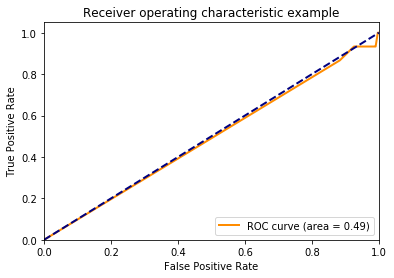

In [448]:
plot_auc_roc(data.val_y, val_probabilities)

In [435]:
roc_auc_score(data.val_y, val_probabilities)

0.4906148867313916

In [1086]:
learner[-1]

BatchNorm1d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

<br>
<br>
<a id="model_predictions"> </a>
# 6. Model predictions

<br>
## 6.1 Making the test set predictions

Set the is_test flag to True to tell the model to predict on the test set.<br>

In [82]:
test_predictions_array = learner.predict(is_test=True)

In [83]:
test_item_id

0        100001
1        100005
2        100013
3        100028
4        100038
5        100042
6        100057
7        100065
8        100066
9        100067
10       100074
11       100090
12       100091
13       100092
14       100106
15       100107
16       100109
17       100117
18       100128
19       100141
20       100150
21       100168
22       100169
23       100170
24       100171
25       100172
26       100184
27       100187
28       100212
29       100222
          ...  
48714    455963
48715    455965
48716    456007
48717    456008
48718    456009
48719    456010
48720    456011
48721    456013
48722    456028
48723    456058
48724    456111
48725    456114
48726    456115
48727    456116
48728    456119
48729    456120
48730    456122
48731    456123
48732    456166
48733    456167
48734    456168
48735    456169
48736    456170
48737    456189
48738    456202
48739    456221
48740    456222
48741    456223
48742    456224
48743    456250
Name: SK_ID_CURR, Length

It will predict the probabilities for all the rows in our dataset

In [ ]:
np.shape(test_predictions)

Check the output dimension is correct. The number of items_id of the test set should be equal to the predictions.

In [85]:
if np.shape(test_predictions)[0] == test_df["item_id"].count():
    print("Output dimension correct")
else:
    print("FATAL ERROR, output dimension doesn't match the number items")

NameError: name 'test_predictions' is not defined

In [86]:
data.test_ds.cats[0:13]

array([[ 1,  1,  1,  2,  1,  7,  7,  2,  2,  2,  2,  2,  1,  2,  1,  2,  0,  6, 19, 29],
       [ 1,  2,  1,  2,  1,  7,  7,  5,  2,  2,  2,  2,  1,  2,  1,  1, 10,  1, 10, 43],
       [ 1,  2,  2,  2,  1,  0,  7,  2,  2,  2,  2,  2,  1,  2,  1,  1,  5,  2, 15, 55],
       [ 1,  1,  1,  2,  3,  7,  7,  5,  2,  2,  2,  2,  1,  2,  2,  1, 15,  7, 12,  6],
       [ 1,  2,  2,  1,  2,  7,  7,  5,  2,  2,  2,  2,  2,  2,  1,  1,  0,  1,  6,  6],
       [ 1,  1,  2,  2,  1,  7,  4,  5,  2,  2,  2,  2,  1,  2,  2,  1,  5,  2, 16, 12],
       [ 1,  2,  2,  2,  3,  7,  7,  2,  2,  2,  2,  2,  1,  2,  1,  1,  7,  5, 10, 27],
       [ 1,  2,  1,  2,  1,  7,  7,  2,  4,  6,  2,  2,  2,  2,  2,  1,  4,  1,  8, 43],
       [ 1,  1,  1,  2,  1,  7,  4,  2,  2,  2,  2,  2,  1,  2,  1,  1,  4,  5, 19, 40],
       [ 1,  1,  2,  2,  2,  2,  7,  2,  1,  2,  2,  2,  2,  2,  2,  1, 15,  6, 15, 47],
       [ 1,  1,  1,  2,  1,  7,  3,  5,  2,  2,  2,  1,  1,  2,  2,  1,  0,  6, 12, 58],
       [ 1,  1,  1,  

In [87]:
processed_test_df.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_ANNUITY_na,AMT_GOODS_PRICE_na,OWN_CAR_AGE_na,CNT_FAM_MEMBERS_na,EXT_SOURCE_1_na,EXT_SOURCE_2_na,EXT_SOURCE_3_na
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1,1,1,2,1,7,7,2,2,2,...,1.781131,1.441565,-2.038370,-0.006247,-0.030081,0.717888,-0.00255,-1.136918,-0.046378,-0.497269
100005,1,2,1,2,1,7,7,5,2,2,...,0.435266,-1.167540,-0.473478,-0.006247,-0.030081,0.717888,-0.00255,-1.136918,-0.046378,-0.497269
100013,1,2,2,2,1,0,7,2,2,2,...,0.012103,0.970733,0.545375,-0.006247,-0.030081,-1.392976,-0.00255,0.879571,-0.046378,-0.497269
100028,1,1,1,2,3,7,7,5,2,2,...,0.153673,-0.025286,0.555178,-0.006247,-0.030081,0.717888,-0.00255,-1.136918,-0.046378,-0.497269
100038,1,2,2,1,2,7,7,5,2,2,...,-2.167493,-0.465323,0.112062,-0.006247,-0.030081,-1.392976,-0.00255,-1.136918,-0.046378,2.010984


<br>
## 6.2 Submission

###  Format

The format of the csv submission file for the challenge: <br><br>
    ID, MDR<br>
    2,0<br>
    5,0<br>
    6,0<br>

###  Item id dataframe
We use the test_item_id dataframe from the sorted test df.

In [88]:
item_id_df = test_item_id
#item_id_df = test_item_id.reset_index().drop(['activation_date'], axis=1)

In [89]:
item_id_df.head()

0    100001
1    100005
2    100013
3    100028
4    100038
Name: SK_ID_CURR, dtype: int64

###  Test predictions dataframe
We use the predicitions array to build the dataframe

In [90]:
test_predictions_df  = pd.DataFrame(test_predictions_array, columns=['TARGET'])

In [91]:
#test_predictions_df = test_predictions_df.clip(0,1)

In [92]:
test_predictions_df.head()

,TARGET
0,0.070715
1,0.175996
2,0.035918
3,0.023198
4,0.153396


###  Submission dataframe
Concat both dataframes to generate the submission dataframe

In [93]:
submission_df = pd.concat([item_id_df, test_predictions_df], axis=1)

In [94]:
submission_df

,SK_ID_CURR,TARGET
0,100001,0.070715
1,100005,0.175996
2,100013,0.035918
3,100028,0.023198
4,100038,0.153396
5,100042,0.050149
6,100057,0.008147
7,100065,0.045495
8,100066,0.008310
9,100067,0.094229


<br>
### Submission csv file

Define the submission name and path.

In [95]:
submission_filename = "submission3"
submission_path = f"{INPUT_PATH}{s}submission{s}{submission_filename}.csv"

Create the submission file without the index column.

In [96]:
submission_df.to_csv(submission_path,index=False)

Generate a link to a direct download of the submission file.

In [111]:
FileLink(submission_path)

C:\Users\David\Desktop\Kaggle\avito\structured\input\submission\submission5.csv

Visualize sample submission.

In [90]:
sample_submission_df = pd.read_csv(f"{INPUT_PATH}{s}submission{s}sample_submission.csv")

In [91]:
sample_submission_df

,item_id,deal_probability
0,6544e41a8817,0.5
1,65b9484d670f,0.5
2,8bab230b2ecd,0.5
3,8e348601fefc,0.5
4,8bd2fe400b89,0.5
5,c63dbd6c657f,0.5
6,6d1a410df86e,0.5
7,e8d3e7922b80,0.5
8,2bc1ab208462,0.5
9,7e05d77a9181,0.5
